## Physical Geography

In [12]:
%load_ext autoreload
%autoreload 2

from world_simulator import run_river_skeleton_pipeline, test_noise, generate_fractal_noise
from world_simulator import GPUThermalEroder, CoastalTaper

from world_simulator import HydrologyAnalyzer, validate_arrow_directions, plot_flow, CalculateFlowMagnitude, plot_river_hierarchy, assign_river_widths, plot_river_physics, save_hydro_network, validate_topology_continuity




import os
import geopandas as gpd
import numpy as np
import rasterio
from gdgtm import change_raster_res


vector_src_dir = "/home/pete/Documents/wfrp/source_vectors/"
raster_src_dir = "/home/pete/Documents/wfrp/source_rasters/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## River and sea setup

Here we take a georeferenced, trimmed corase altitude map, we load it, increase resolution, and then we smooth it.

We use an erosion approach to overal smoothing and aim for Int16 data type - which gives us some serious mileage in the "disk saving department" - 100s of MBs.

The exact maths are indicated in the class docstring for the GPUThermalEroder. For now it is relevant to note that we went for a short erosion (100 steps), slow erosion rate (0.05), and a high threshold of 2. What this means is that we preserve most of the high ground on the map, while introducing just a little smoothing around the slopes to remove the blockiness. Not perfect, but the step below will take care of doing perfect :)



### Vectorizing the river net from QGIS polys

The goal here is to take a bunch of QGIS polygons and change them into an actual net of lines for downstream processing.

In [ ]:
# if __name__ == "__main__":
#     # Example configuration
#     IN_FILE = os.path.join(vector_src_dir, "wfrp_empire_rivers_poly.gpkg")
#     OUT_FILE = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
    
#     # Config
#     GAP_TOLERANCE = 3500     # 20km gap filling
#     INTERP_DISTANCE = 250     # 500m vertex resolution
#     PRUNE = 3500
    
#     if os.path.exists(IN_FILE):
#         run_river_skeleton_pipeline(IN_FILE, OUT_FILE, GAP_TOLERANCE, INTERP_DISTANCE, PRUNE)
#     else:
#         print(f"File not found: {IN_FILE}")

In [ ]:
# ### Phase 1: Make the rivers flow and make them have the right size.

# if __name__ == "__main__":

#     # rivers_path = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
#     sea_path = os.path.join(vector_src_dir, "wfrp_empire_sea_poly.gpkg")
#     lakes_path = os.path.join(vector_src_dir, "wfrp_empire_lakes_poly.gpkg")
#     rivers_path = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
    
#     rivers = gpd.read_file(rivers_path) # The output from skeletonization
#     sea = gpd.read_file(sea_path)       # You need this
#     lakes = gpd.read_file(lakes_path)   # You need this (Canonical lakes)

#     ### Step 1: Orient the rivers in the correct direction.
#     analyzer = HydrologyAnalyzer(rivers, sea, lakes)
#     oriented_rivers = analyzer.run()
#     validate_arrow_directions(oriented_rivers, analyzer.G)
#     # plot_flow(oriented_rivers, sea, lakes)

#     ### Step 2: Establish river hierarchy
#     # 1. Get the Directed Graph from the Phase 1 Analyzer
#     flow_calculator = CalculateFlowMagnitude(analyzer.DiG)
#     # 2. Calculate Magnitude
#     dag_with_flow = flow_calculator.run()
#     # 3. Visualize
#     # plot_river_hierarchy(dag_with_flow, sea, lakes)

In [ ]:
# if __name__ == "__main__":
#     OUT_FILE = os.path.join(vector_src_dir, "wfrp_empire_major_rivers_net.gpkg")
#     ### Step 3: Work out river widths:
#     rivers_with_width = assign_river_widths(
#         dag_with_flow, 
#         min_width=20.0,    # Source streams are 20m wide
#         max_width=1000.0,   # The Reik is 800m wide at Altdorf - we make it 1000 for our 250m grid.
#         scale_factor=100.0  # Multiplier for the log growth
#     )
    
#     # 2. Restore CRS (Important for buffering!)
#     rivers_with_width.set_crs(rivers.crs, inplace=True)
    
#     # 3. Visualize
#     # plot_river_physics(rivers_with_width, sea, lakes)
#     save_hydro_network(rivers_with_width, OUT_FILE)

In [4]:
# validate_topology_continuity(rivers_with_width)

--- TOPOLOGY CONTINUITY CHECK ---
Checked 100 junctions.
SUCCESS: Water flows continuously from line to line.


### Sea set-up

Here we prep the sea



In [1]:
# =============================================================================
#  IMPORTS
# =============================================================================

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import geopandas as gpd
import rasterio

# from world_simulator.terrain_engine import CoordinateEngine
# Added necessary utility functions for Step 2
from world_simulator.misc_utils import (
    vector_to_mask, 
    generate_fractal_mask, 
    measure_fractal_dimension,
    repair_mask_artifacts
)


/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074409.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074410.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074410.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074410.log


In [2]:
# =============================================================================
#  STEP 1: LOAD CONTEXT DATA
# =============================================================================

vector_src = "/home/pete/Documents/wfrp/source_vectors"
raster_src = "/home/pete/Documents/wfrp/source_rasters"

# A. The Base DEM (Canvas & Starting Heights)
base_dem_path = os.path.join(raster_src, "wfrp_empire_smoothed_topo.tif") # From your previous step
with rasterio.open(base_dem_path) as src:
    base_profile = src.profile
    base_shape = (src.height, src.width)
    base_elevation = src.read(1) # Start with existing terrain

# B. Vectors
rivers_gdf = gpd.read_file(os.path.join(vector_src, "wfrp_empire_major_rivers_net.gpkg"))
lakes_gdf = gpd.read_file(
    os.path.join(vector_src, "wfrp_empire_lakes_poly.gpkg"),
    layer="wfrp_empire_lakes")
sea_gdf = gpd.read_file(os.path.join(vector_src, "wfrp_empire_sea_poly.gpkg")) # Explicit Sea Load



In [3]:
# =============================================================================
#  STEP 2: PRE-PROCESS COAST (Measure & Mimic)
# =============================================================================
# --- A. COASTAL ANALYSIS ---
print("Analyzing Coastline Physics...")

# 1. Rasterize (Get the shape)
raw_sea_mask = vector_to_mask(sea_gdf, base_profile)

# Define the artifact zones (Map edges/NoData boundaries)
# Format: (West_Col, North_Row, East_Col, South_Row)
artifact_boxes = [
    (0, 1050, 100, 1300),   # Box 1: West edge artifact
    (3500, 0, 7100, 900)    # Box 2: Northern edge artifact
]

# 2. Measure the "Native" Fractal Dimension
# We measure the complexity at coarse scales (e.g., 2km to 64km).
# This tells us if the coast is "Scottish" (High D) or "Floridian" (Low D).
# We stop at min_scale=16px (~2km) to avoid reading the square pixel artifacts.
measured_d = measure_fractal_dimension(
    mask=raw_sea_mask,
    min_scale=16,   # Ignore details smaller than ~2km
    max_scale=512,  # Measure up to ~64km bays
    exclusion_boxes=artifact_boxes  # <--- Plugged in here
)

# print(f"Measured Fractal Dimension: {measured_d}")

# Safety Clamp: Real coastlines rarely exceed 1.5 or drop below 1.1
measured_d = np.clip(measured_d, 1.1, 1.45)
print(f"  > Detected Fractal Dimension: {measured_d:.3f}")

# 3. Synthesize Detail
# We use the measured D to generate the sub-pixel details.
fractal_sea_mask = generate_fractal_mask(
    mask=raw_sea_mask,
    fractal_dimension=measured_d,  # <--- The Measurement informs the Synthesis
    scale=20.0,
    seed=123
)

# 4. Repair Boundaries
# We surgically restore the straight edges in the artifact boxes
# to prevent the fractal noise from 'chewing' up the map border.
print("Repairing map boundary artifacts...")
fractal_sea_mask = repair_mask_artifacts(
    fractal_mask=fractal_sea_mask,
    reference_mask=raw_sea_mask,      # The clean original
    boxes=artifact_boxes,             # <--- Plugged in here again
    base_dem=base_elevation,          # Check for valid data
    nodata_value=base_profile.get('nodata', -32768)
)

Analyzing Coastline Physics...
INFO: Rasterizing 11 vector features into mask...
  > Detected Fractal Dimension: 1.224
Repairing map boundary artifacts...
INFO: Repairing artifacts in 2 zones...


In [4]:
# =============================================================================
#  DEBUG EXPORT: FRACTAL SEA MASK
# =============================================================================
output_mask_path = os.path.join(raster_src, "wfrp_coast_mask_test.tif")
print(f"Exporting debug mask to {output_mask_path}...")

# Prepare Profile
mask_profile = base_profile.copy()
mask_profile.update({
    'dtype': 'uint8',
    'count': 1,
    'compress': 'lzw',
    'nodata': 0 
})

with rasterio.open(output_mask_path, 'w', **mask_profile) as dst:
    # Cast Boolean (True/False) to Uint8 (1/0)
    # OPTIONAL: Multiply by 255 so it appears as Black/White in QGIS immediately
    # without needing to stretch the histogram manually.
    debug_data = fractal_sea_mask.astype('uint8') * 255
    
    dst.write(debug_data, 1)

print("Debug export complete.")

Exporting debug mask to /home/pete/Documents/wfrp/source_rasters/wfrp_coast_mask_test.tif...
Debug export complete.


## Topography: 

The plan is outlined here: https://github.com/pete-jacobsson/enemy_rebuilt/wiki/Topography

### PHASE 1: IMPORTS & RAW DATA INGESTION

In [4]:
%load_ext autoreload
%autoreload 2


import gc
import geopandas as gpd

import numpy as np
import os

import pandas as pd
import rasterio
from rasterio.plot import show

from world_simulator import (
    rasterize_vector_to_disk,
    rasterize_variable_width_rivers,
    rasterize_uint8_to_disk
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251226_124802.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251226_124802.log


In [5]:
# 1. Configuration: File Paths
# -----------------------------------------------------------------------------
INPUT_DIR = "/home/pete/Documents/wfrp"

# File definitions matching your manifest
files = {
    "gcm":    os.path.join(INPUT_DIR, "source_vectors", "wfrp_empire_geo_control.gpkg"),  # 5-Zone Vector Mask
    "dem":    os.path.join(INPUT_DIR, "source_rasters", "wfrp_empire_topo_high_res.tif"),  # Coarse Heightmap
    "rivers": os.path.join(INPUT_DIR, "source_vectors", "wfrp_empire_major_rivers_net.gpkg"),        # River Vectors
    "lakes":  os.path.join(INPUT_DIR, "source_vectors", "wfrp_empire_lakes_high_res_poly.gpkg"),         # Lake Polygons
    "sea":    os.path.join(INPUT_DIR, "source_vectors", "wfrp_empire_sea_high_res_poly.gpkg"),            # Sea Polygons
    "talabec": os.path.join(INPUT_DIR, "source_vectors", "wfrp_talabec_throughline.gpkg")       # The Talabec throughline
}

# 2. Load Raster Data (The Base DEM)
# -----------------------------------------------------------------------------
# We keep the source open or read immediately into memory. 
# Here we read the data and profile to establish the baseline grid/CRS.
try:
    with rasterio.open(files['dem']) as src:
        base_dem_data = src.read(1)
        base_profile = src.profile   # Metadata (CRS, Transform, Width, Height)
        base_bounds = src.bounds     # Physical extent
    
    print(f"SUCCESS: Loaded Base DEM.")
    print(f"  - Shape: {base_dem_data.shape}")
    print(f"  - CRS: {base_profile['crs']}")
    print(f"  - Bounds: {base_bounds}")

except Exception as e:
    print(f"ERROR: Could not load DEM. {e}")

# 3. Load Vector Data (Geological Mask, Hydro, Coastline)
# -----------------------------------------------------------------------------
# We load these as GeoDataFrames. No rasterization yet.
try:
    # A. Geological Control Map (Zone 1-5)
    gdf_gcm = gpd.read_file(files['gcm'])
    print(f"SUCCESS: Loaded GCM ({len(gdf_gcm)} polygons).")

    # B. Hydrology
    gdf_rivers = gpd.read_file(files['rivers'])
    print(f"SUCCESS: Loaded Rivers ({len(gdf_rivers)} segments).")

    gdf_lakes = gpd.read_file(files['lakes'])
    print(f"SUCCESS: Loaded Lakes ({len(gdf_lakes)} polygons).")

    # C. Coastline / Sea
    gdf_sea = gpd.read_file(files['sea'])
    print(f"SUCCESS: Loaded Sea Mask ({len(gdf_sea)} polygons).")

except Exception as e:
    print(f"ERROR: Could not load vector data. {e}")

# 4. Quick CRS Consistency Check
# -----------------------------------------------------------------------------
# All vectors must match the DEM's CRS.
vectors = {'gcm': gdf_gcm, 'rivers': gdf_rivers, 'lakes': gdf_lakes, 'sea': gdf_sea}
dem_crs = base_profile['crs']

print("\n--- CRS Consistency Check ---")
for name, gdf in vectors.items():
    if gdf.crs != dem_crs:
        print(f"WARNING: {name} CRS ({gdf.crs}) does not match DEM ({dem_crs}). Reprojection required later.")
    else:
        print(f"OK: {name} matches DEM CRS.")

SUCCESS: Loaded Base DEM.
  - Shape: (10562, 16395)
  - CRS: PROJCS["WFRP_Big_World_Lambert",GEOGCS["WFRP_Big_Datum",DATUM["WFRP_Big_Datum",SPHEROID["International_1924_Scaled_x1.414",9020404.57,297],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",30],PARAMETER["central_meridian",10],PARAMETER["standard_parallel_1",43],PARAMETER["standard_parallel_2",62],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  - Bounds: BoundingBox(left=-635133.80997, bottom=2700483.50684, right=1414241.1900300002, top=4020733.50684)
SUCCESS: Loaded GCM (15 polygons).
SUCCESS: Loaded Rivers (112264 segments).
SUCCESS: Loaded Lakes (80 polygons).
SUCCESS: Loaded Sea Mask (493 polygons).

--- CRS Consistency Check ---
OK: gcm matches DEM CRS.
OK: rivers matches DEM CRS.
OK: lakes matches

In [6]:
# =============================================================================
#  PHASE 1.1: PREP SIMPLE MASKS AND SAVE TO DISK
# =============================================================================

# Configuration
OUTPUT_MASK_DIR = os.path.join(INPUT_DIR, "processed_masks")
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

# Define processing targets
# Format: (Input Vector Key, Output Filename, All Touched?)
# Note: 'All Touched=True' is usually better for Lakes/Sea to ensure 
# thin coastal features don't disappear.
targets = [
    ("sea", "mask_sea.tif", True),
    ("lakes", "mask_lakes.tif", True),
    ("talabec", "talabec_throughline.tif", True)
]

print("Starting Rasterization Sequence...")

for key, filename, touch_setting in targets:
    output_path = os.path.join(OUTPUT_MASK_DIR, filename)
    
    # Check if we already loaded it in previous cells, otherwise use path
    source = vectors[key] if 'vectors' in locals() and vectors.get(key) is not None else files[key]
    
    # Execute Function
    rasterize_vector_to_disk(
        vector_source=source,
        template_raster_path=files['dem'],
        output_path=output_path,
        burn_value=1,
        all_touched=touch_setting
    )



Starting Rasterization Sequence...
Rasterizing to mask_sea.tif...
Saved: /home/pete/Documents/wfrp/processed_masks/mask_sea.tif
Rasterizing to mask_lakes.tif...
Saved: /home/pete/Documents/wfrp/processed_masks/mask_lakes.tif
Loading vectors from wfrp_talabec_throughline.gpkg...
Rasterizing to talabec_throughline...
Saved: /home/pete/Documents/wfrp/processed_masks/talabec_throughline


In [7]:
# =============================================================================
#  PHASE 1.2: RASTERIZE VARIABLE WIDTH RIVERS
# =============================================================================

# Configuration
OUTPUT_MASK_DIR = os.path.join(INPUT_DIR, "processed_masks")
RIVER_OUTPUT_FILE = "mask_rivers_variable.tif"
OUTPUT_PATH = os.path.join(OUTPUT_MASK_DIR, RIVER_OUTPUT_FILE)

print("Starting River Rasterization...")

# Check if 'vectors' dict exists from previous cells, otherwise load from file
source = vectors['rivers'] if 'vectors' in locals() and vectors.get('rivers') is not None else files['rivers']

# Execute the variable width rasterization
# We use the 'width' column identified in your printout
rasterize_variable_width_rivers(
    vector_source=source,
    template_raster_path=files['dem'],
    output_path=OUTPUT_PATH,
    width_col='width'
)


Starting River Rasterization...
Buffering river segments by width...
Rasterizing variable widths to mask_rivers_variable.tif...
Saved: /home/pete/Documents/wfrp/processed_masks/mask_rivers_variable.tif


In [8]:
# =============================================================================
#  PHASE 1.3: RASTERIZE GEOLOGICAL CONTROL MAP (GCM)
# =============================================================================
OUTPUT_MASK_DIR = os.path.join(INPUT_DIR, "processed_masks")
GCM_OUTPUT_FILE = "mask_geology.tif"
OUTPUT_PATH = os.path.join(OUTPUT_MASK_DIR, GCM_OUTPUT_FILE)

print("Starting GCM Rasterization...")

# Source Retrieval
source = vectors['gcm'] if 'vectors' in locals() and vectors.get('gcm') is not None else files['gcm']

# Execute Rasterization
# Using 'DN' as identified in your printout
rasterize_uint8_to_disk(
    vector_source=source,
    template_raster_path=files['dem'],
    output_path=OUTPUT_PATH,
    value_col='DN'
)

Starting GCM Rasterization...
Rasterizing Geological Zones (Col: DN) to mask_geology.tif...
Saved: /home/pete/Documents/wfrp/processed_masks/mask_geology.tif


In [9]:
# =============================================================================
#  PHASE 1 CLEANUP
# =============================================================================
print("\nFinalizing Phase 1 Memory Cleanup...")

if 'vectors' in locals():
    del vectors

if 'base_profile' in locals():
    del base_profile
    del base_dem_data

if 'base_bounds' in locals():
    del base_bounds


# Force GC
gc.collect()

print("Phase 1 Complete. All vectors rasterized to 'processed_masks/' and memory cleared.")



Finalizing Phase 1 Memory Cleanup...
Phase 1 Complete. All vectors rasterized to 'processed_masks/' and memory cleared.


### PHASE 2: Macro-Sculpting (The Foundation)

In [37]:
%load_ext autoreload
%autoreload 2

import rasterio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# 1. Configuration: File Paths
# -----------------------------------------------------------------------------
INPUT_DIR = "/home/pete/Documents/wfrp"

# File definitions matching your manifest
files = {
    "gcm":    os.path.join(INPUT_DIR, "processed_masks/mask_geology.tif"),  # 5-Zone Vector Mask
    "dem":    os.path.join(INPUT_DIR, "source_rasters/wfrp_empire_topo_high_res.tif"),  # Coarse Heightmap
}

# 2. Load Raster Data (The Base DEM)
# -----------------------------------------------------------------------------
# We keep the source open or read immediately into memory. 
# Here we read the data and profile to establish the baseline grid/CRS.
try:
    with rasterio.open(files['dem']) as src:
        dem = src.read(1)
        base_profile = src.profile   # Metadata (CRS, Transform, Width, Height)
        base_bounds = src.bounds     # Physical extent

    with rasterio.open(files['gcm']) as src:
        gcm = src.read(1)

    print("dem and gcm loaded!")

except Exception as e:
    print(f"ERROR: Could not load DEM. {e}")

dem and gcm loaded!


#### STEP A: De-stepping
The Canonical DEM is quantified into 5 levels. We apply a wide-radius Gaussian Blur to the base elevation to turn these "steps" into continuous slopes, creating a smooth canvas for detailing.

In [39]:
%load_ext autoreload
%autoreload 2

import os
import rasterio
import numpy as np
from world_simulator import destep_terrain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# 1. Configuration
# -----------------------------------------------------------------------------
# Adjust radius based on your resolution. 
# If 1px ~= 125m, a 64px radius creates ~6km wide slopes.
# Larger radius = smoother, wider ramps between the steps.
BLUR_RADIUS = 64 
ITERATIONS = 3
SCALE_FACTOR = 2  # 1m = 2 units (so 50m = 100 units)

OUTPUT_DIR = os.path.join(INPUT_DIR, "source_rasters")
OUTPUT_FILENAME = "phase2_a_destep.tif"
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [41]:
# 2. Execution
if 'dem' not in locals():
    raise ValueError("Variable 'dem' not found. Load Phase 1 data first.")

# Extract Nodata value from the loaded profile
# If not defined in file, default to -32768 (standard for int16)
src_nodata = base_profile.get('nodata', None)
if src_nodata is None:
    src_nodata = -32768
    print(f"Warning: No Nodata in profile. Assuming {src_nodata}.")
else:
    print(f"Using Nodata Value: {src_nodata}")

# Run Nodata-Aware Smoothing
smoothed_dem = destep_terrain(
    dem_array=dem,
    nodata_value=src_nodata,
    radius=BLUR_RADIUS, 
    iterations=ITERATIONS, 
    scale_factor=SCALE_FACTOR
)

Using Nodata Value: -32768.0
--- Starting Nodata-Aware De-stepping (R=64, I=3) ---
  > Blur Pass 1/3...
  > Blur Pass 2/3...
  > Blur Pass 3/3...
Restoring Nodata and quantizing...


In [42]:
# 3. Save to Compressed GeoTIFF
# -----------------------------------------------------------------------------
print(f"Saving result to {OUTPUT_FILENAME}...")

# Update metadata for the new format
profile = base_profile.copy()
profile.update({
    'driver': 'GTiff',
    'dtype': rasterio.int16,
    'count': 1,
    'compress': 'lzw',
    'predictor': 2,  # Horizontal differencing (good for elevation data)
    'nodata': -32768 # Standard int16 nodata value
})

with rasterio.open(OUTPUT_PATH, 'w', **profile) as dst:
    dst.write(smoothed_dem, 1)

print(f"SUCCESS: De-stepping complete.")
print(f"  - Output shape: {smoothed_dem.shape}")
print(f"  - Min/Max values: {np.min(smoothed_dem)} / {np.max(smoothed_dem)}")
print(f"  - Scale: 1 unit = {1/SCALE_FACTOR} meters")

Saving result to phase2_a_destep.tif...
SUCCESS: De-stepping complete.
  - Output shape: (10562, 16395)
  - Min/Max values: -32768 / 32424
  - Scale: 1 unit = 0.5 meters


In [43]:
# 4. Cleanup Memory
# -----------------------------------------------------------------------------
# We delete the smoothed array from RAM. 
# We keep 'dem' (original) and 'gcm' for the next prompt (Step B).
del dem
del smoothed_dem
import gc
gc.collect()

0

#### Step B: The Uplifts
* Logic: The canonical DEM currently sets the base elevation for both Marienburg (Zone 5) and Wissenland (Zone 3) to 0m. To enforce the physical reality of the "Southern Forebulge," we must mechanically separate them.
* Action: We target Zone 3 pixels that are currently at 0m base elevation. We apply a procedural Uplift of +200m.
    * Effect: This raises the Reikland/Stirland tableland above the northern sedimentation basins.
    * Hydrology: This creates the necessary gravitational potential energy. The Reik is no longer flowing across a flat plane; it is now flowing off a plateau, forcing it to incise the "Reik Canyon" and "Altdorf Gap" as it exits the raised Zone 3 and drops into the Zone 5/4 lowlands.



In [17]:
%load_ext autoreload
%autoreload 2

import os
import rasterio
import numpy as np
from world_simulator import apply_zone_elevation_change

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# 1. Configuration
# -----------------------------------------------------------------------------
# Output
INPUT_RASTER_PATH = os.path.join(INPUT_DIR, "source_rasters", "phase2_a_destep.tif")

OUTPUT_DIR = os.path.join(INPUT_DIR, "source_rasters")
OUTPUT_FILENAME = "phase2_b_uplift.tif"
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

In [19]:
# 2. Load Data
# -----------------------------------------------------------------------------
print(f"Loading Step A DEM: {os.path.basename(INPUT_RASTER_PATH)}...")
with rasterio.open(INPUT_RASTER_PATH) as src:
    dem_step_a = src.read(1)
    profile = src.profile
    nodata_val = src.nodata

Loading Step A DEM: phase2_a_destep.tif...


In [20]:
# 3a. Execution - OE3
# -----------------------------------------------------------------------------
# Parameters
TARGET_ZONE = 3      # OE3 Foreland
UPLIFT_METERS = 200  # +200m Forebulge
SCALE_FACTOR = 2     # 100 units = 50m

uplifted_dem = apply_zone_elevation_change(
    dem_array=dem_step_a,
    mask_array=gcm,
    zone_id=TARGET_ZONE,
    elevation_change_m=UPLIFT_METERS,
    scale_factor=SCALE_FACTOR,
    nodata_value=nodata_val
)

--- Applying Zonal Uplift (Zone 3: 200m) ---
  > Targeted 37268405 pixels.


In [21]:
# 3b. Execution - Talabec valley
# -----------------------------------------------------------------------------
# Parameters
TARGET_ZONE = 4      # Talabec subsidance zone
UPLIFT_METERS = 100  # +100m (above sea-level security)
SCALE_FACTOR = 2     # 100 units = 50m

uplifted_dem = apply_zone_elevation_change(
    dem_array=uplifted_dem,
    mask_array=gcm,
    zone_id=TARGET_ZONE,
    elevation_change_m=UPLIFT_METERS,
    scale_factor=SCALE_FACTOR,
    nodata_value=nodata_val
)

--- Applying Zonal Uplift (Zone 4: 100m) ---
  > Targeted 13895842 pixels.


In [22]:
# 3c. Execution - OE2
# -----------------------------------------------------------------------------
# Parameters
TARGET_ZONE = 2      # OE2
UPLIFT_METERS = 250  # +100m (above sea-level security)
SCALE_FACTOR = 2     # 100 units = 50m

uplifted_dem = apply_zone_elevation_change(
    dem_array=uplifted_dem,
    mask_array=gcm,
    zone_id=TARGET_ZONE,
    elevation_change_m=UPLIFT_METERS,
    scale_factor=SCALE_FACTOR,
    nodata_value=nodata_val
)

--- Applying Zonal Uplift (Zone 2: 250m) ---
  > Targeted 35533907 pixels.


In [23]:
# 4. Save Output
# -----------------------------------------------------------------------------
print(f"Saving result to {OUTPUT_FILENAME}...")

# Ensure profile matches target specs (int16 LZW)
profile.update({
    'driver': 'GTiff',
    'dtype': rasterio.int16,
    'count': 1,
    'compress': 'lzw',
    'predictor': 2,
    'nodata': nodata_val
})

with rasterio.open(OUTPUT_PATH, 'w', **profile) as dst:
    dst.write(uplifted_dem, 1)

print(f"SUCCESS: Step B Complete.")
print(f"  - Uplifted Zone {TARGET_ZONE} by {UPLIFT_METERS}m.")
print(f"  - Output saved to: {OUTPUT_PATH}")

Saving result to phase2_b_uplift.tif...
SUCCESS: Step B Complete.
  - Uplifted Zone 2 by 250m.
  - Output saved to: /home/pete/Documents/wfrp/source_rasters/phase2_b_uplift.tif


In [24]:
# 5. Cleanup
# -----------------------------------------------------------------------------
del dem_step_a
del uplifted_dem
import gc
gc.collect()

0

#### Step C:  The Subsidence Ramp:

Logic: In Zone 4, we forcibly blend the terrain downwards into a trench shape where the Southern Plate dives under the Northern Anvil, ensuring the Talabec has a valid tectonic container.

In [64]:
%load_ext autoreload
%autoreload 2

import os
import rasterio
import numpy as np
from world_simulator import apply_south_bank_ramp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# 1. Configuration
# -----------------------------------------------------------------------------
# Output
INPUT_RASTER_PATH = os.path.join(INPUT_DIR, "source_rasters", "phase2_b_uplift.tif")

OUTPUT_DIR = os.path.join(INPUT_DIR, "source_rasters")
OUTPUT_FILENAME = "phase2_c_subsidence.tif"
OUTPUT_PATH = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

throughline_path  = os.path.join(INPUT_DIR, "processed_masks", "talabec_throughline.tif")

# Tectonic Parameters
TARGET_ZONE = 4      # The Talabec Corridor
INCLINE_HEIGHT = 150 # Max height to ADD at the southern edge (0 at river -> 150 at edge)
SCALE_FACTOR = 2

In [60]:
# 2. Load Data
# -----------------------------------------------------------------------------
print(f"Loading Step B DEM: {os.path.basename(INPUT_RASTER_PATH)}...")
with rasterio.open(INPUT_RASTER_PATH) as src:
    dem_step_b = src.read(1)
    profile = src.profile
    nodata_val = src.nodata

Loading Step B DEM: phase2_b_uplift.tif...


In [61]:
# Load the Talabec throughline
# -----------------------------------------------------------------------------
print(f"Loading throughline: {os.path.basename(throughline_path)}...")

with rasterio.open(throughline_path) as src:
    throughline = src.read(1)


Loading throughline: talabec_throughline.tif...


--- Applying South Bank Incline (Zone 4) ---
  > Crop Window: 3574:6865, 1353:15450
  > Step 1: Isolating South Bank (Column Voting)...
    [Analysis] Sampling 20 columns for North/South check...
    [Vote Result] Winner: Blob #2 with 18 / 18 votes.
    [Tally] {1: 0, 2: 18}


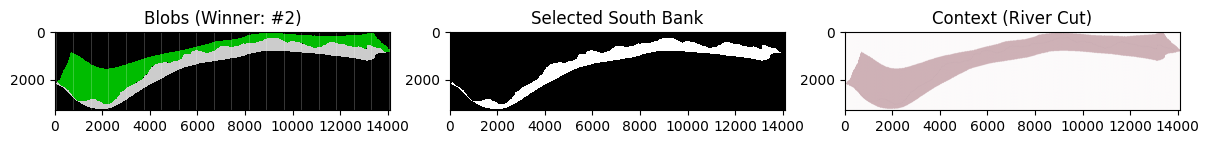

  > Step 2: Calculating Normalized Incline (Shoreline Propagation)...


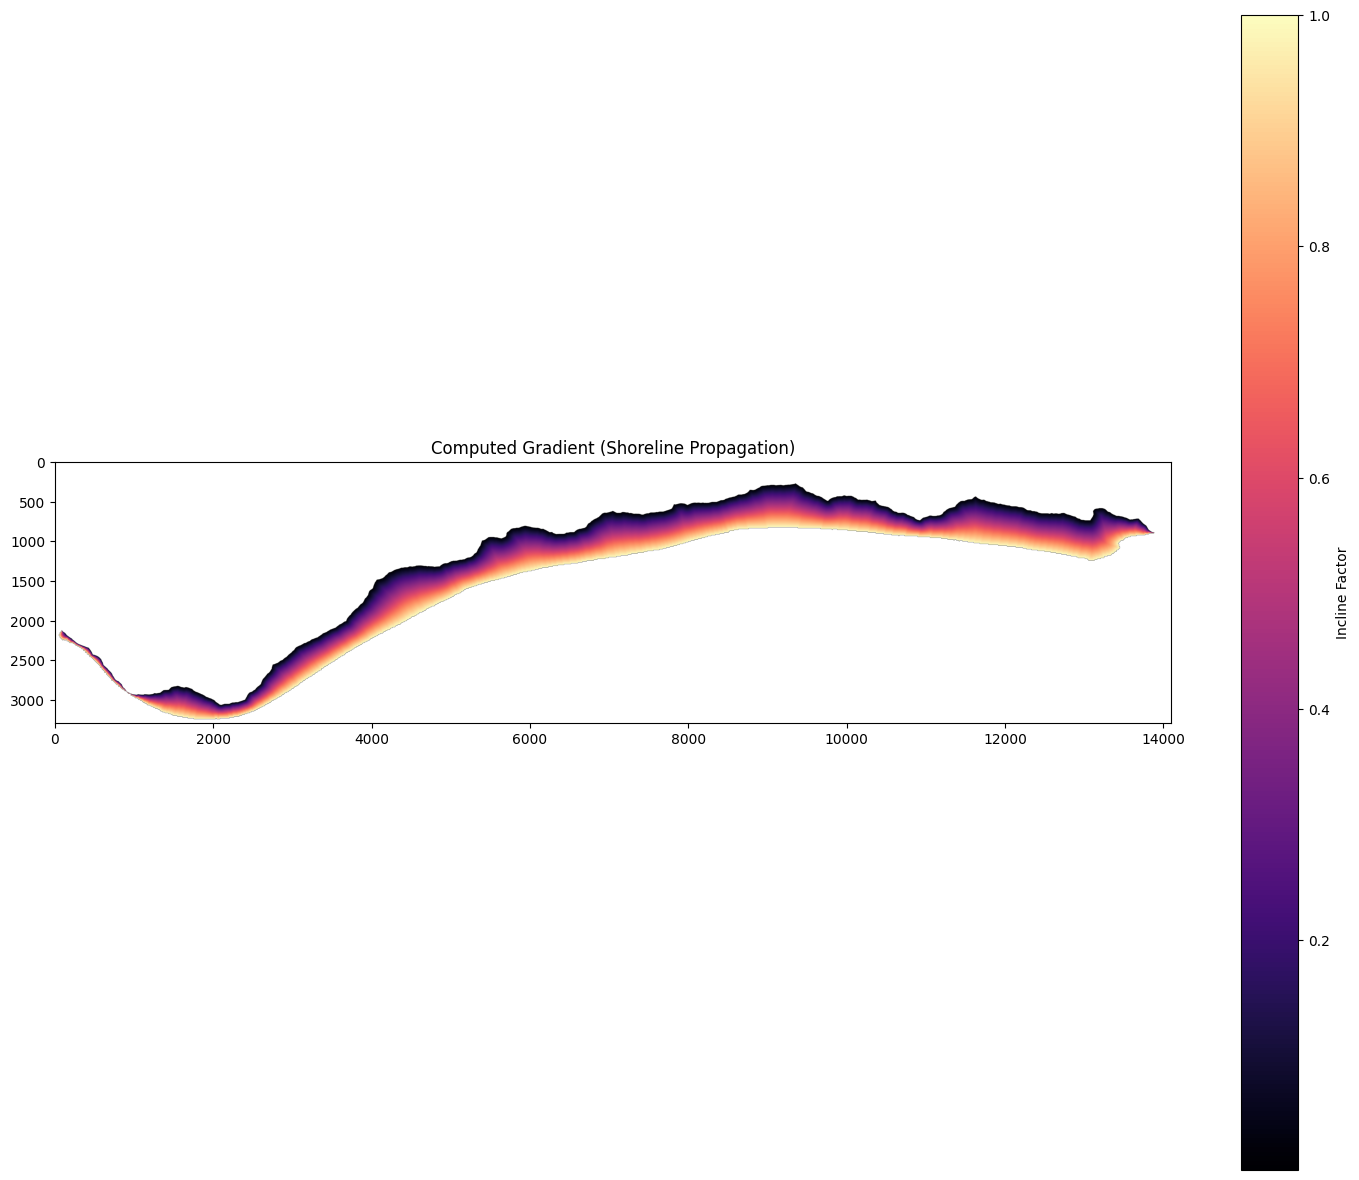

  > Step 3: Injecting +150m Incline...


In [74]:
# 3. Execution
# -----------------------------------------------------------------------------
# This function handles the blob detection internally
tilted_dem = apply_south_bank_ramp(
    dem_array=dem_step_b,
    gcm_array=gcm,
    throughline_mask=throughline,
    target_zone_id=TARGET_ZONE,
    incline_m=INCLINE_HEIGHT,
    scale_factor=SCALE_FACTOR
)

In [75]:
# 4. Save Output
# -----------------------------------------------------------------------------
print(f"Saving result to {OUTPUT_FILENAME}...")

profile.update({
    'driver': 'GTiff',
    'dtype': rasterio.int16,
    'count': 1,
    'compress': 'lzw',
    'predictor': 2,
    'nodata': nodata_val
})

with rasterio.open(OUTPUT_PATH, 'w', **profile) as dst:
    dst.write(tilted_dem, 1)

print(f"SUCCESS: Step C Complete.")
print(f"  - Output saved to: {OUTPUT_PATH}")

Saving result to phase2_c_subsidence.tif...
SUCCESS: Step C Complete.
  - Output saved to: /home/pete/Documents/wfrp/source_rasters/phase2_c_subsidence.tif


In [76]:
# 5. Cleanup
del dem_step_b
del throughline
del gcm
del tilted_dem
import gc
gc.collect()

45138

### Phase 3: The Coordinate Warp (River Gravity)

Goal: Align the mathematical fabric of the world with the hydrological reality.

    Action: We generate a "Warp Field" based on the River Vectors.
    Effect: The coordinate system ( x , y ) is pinched and pulled towards major rivers. This ensures that when we apply tectonic noise in the next phase, the mountain ridges and valleys will naturally curve to follow the river flow, avoiding the "rivers crossing ridges" paradox.


In [11]:
%load_ext autoreload
%autoreload 2

import os
import gc
import numpy as np
import rasterio
from world_simulator import compute_warp_artifacts, apply_hydraulic_carve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# 1. Configuration: File Paths
# -----------------------------------------------------------------------------
WD = "/home/pete/Documents/wfrp"

# File definitions matching your manifest
files = {
    "gcm":    os.path.join(WD, "processed_masks", "mask_geology.tif"),  # 5-Zone Vector Mask
    "dem":    os.path.join(WD, "source_rasters", "phase2_c_subsidence.tif"),  # Coarse Heightmap
    "rivers": os.path.join(WD, "processed_masks", "mask_rivers_variable.tif")
}


# Output files
FILE_WARP_X   = os.path.join(WD, "source_rasters", "phase3_warp_x.tif")
FILE_WARP_Y   = os.path.join(WD, "source_rasters", "phase3_warp_y.tif")
FILE_INFLUENCE= os.path.join(WD, "source_rasters", "phase3_warp_influence.tif")
FILE_CARVED   = os.path.join(WD, "source_rasters", "phase3_b_carved.tif")


PIXEL_SIZE_M = 125.0
BASE_RADIUS_KM = 4.0

ZONE_PARAMS = {
    1: {'width_mod': 0.5, 'strength_mod': 1.2},  # Mountains
    2: {'width_mod': 0.7, 'strength_mod': 1.0},  # Hills
    3: {'width_mod': 0.7, 'strength_mod': 1.0},
    4: {'width_mod': 1.5, 'strength_mod': 0.5},  # Marsh
    5: {'width_mod': 2.0, 'strength_mod': 0.3},  # Delta
    9: {'width_mod': 1.0, 'strength_mod': 0.0},  # Sea
}




# 2. Load Raster Data (The Base DEM)
# -----------------------------------------------------------------------------
# We keep the source open or read immediately into memory. 
# Here we read the data and profile to establish the baseline grid/CRS.
try:
    with rasterio.open(files['dem']) as src:
        dem = src.read(1)
        base_profile = src.profile   # Metadata (CRS, Transform, Width, Height)
        base_bounds = src.bounds     # Physical extent

    with rasterio.open(files['gcm']) as src:
        gcm = src.read(1)

    with rasterio.open(files['rivers']) as src:
        rivers = src.read(1)

    print("dem, gcm and rivers loaded!")

except Exception as e:
    print(f"ERROR: Could not load DEM. {e}")

dem, gcm and rivers loaded!


In [3]:
# 3. Execution - warping
# -----------------------------------------------------------------------------
# DOWNSAMPLE FACTOR: 0.5 is recommended for 4GB RAM.
# It processes at 8k x 5k, then upscales.
warp_x, warp_y, influence = compute_warp_artifacts(
    river_mask=rivers,
    geology_mask=gcm,
    zone_params=ZONE_PARAMS,
    pixel_size_m=PIXEL_SIZE_M,
    base_radius_km=BASE_RADIUS_KM,
    downsample_factor=0.5 
)

--- Computing Warp Artifacts (Scale: 0.5) ---
  > Downsampling masks...
    Original: 16395x10562 -> Processed: 8198x5281
  > Calculating EDT...
  > Mapping Geology...
  > Running Numba Warp Kernel (Parallel)...
  > Upscaling to full resolution...


In [4]:
# 4. Save 3 Separate Outputs (Float16)
# -----------------------------------------------------------------------------
print("Saving individual rasters (Float32)...")

base_profile.update({
    'driver': 'GTiff',
    'dtype': rasterio.float32,
    'count': 1,
    'compress': 'lzw',
    'predictor': 2
})

# NOTE: Many GeoTiff viewers struggle with Float16. 
# We kept them as Float16 in RAM to survive the upscale. 
# Writing them as Float32 to disk is safer, or keep Float16 if you are sure.
# Here we write the float16 array; rasterio/gdal usually promotes on write if needed.

print(f"  > Saving {os.path.basename(FILE_WARP_X)}...")
with rasterio.open(FILE_WARP_X, 'w', **base_profile) as dst:
    dst.write(warp_x.astype(np.float32), 1) # Write as f32 for safety

print(f"  > Saving {os.path.basename(FILE_WARP_Y)}...")
with rasterio.open(FILE_WARP_Y, 'w', **base_profile) as dst:
    dst.write(warp_y.astype(np.float32), 1)

print(f"  > Saving {os.path.basename(FILE_INFLUENCE)}...")
with rasterio.open(FILE_INFLUENCE, 'w', **base_profile) as dst:
    dst.write(influence.astype(np.float32), 1)

# Cleanup
del warp_x, warp_y, influence
gc.collect()

Saving individual rasters (Float32)...
  > Saving phase3_warp_x.tif...
  > Saving phase3_warp_y.tif...
  > Saving phase3_warp_influence.tif...


0

In [13]:
# 5. Carving Parameters
# -----------------------------------------------------------------------------
# "Drill deep in rock, stay shallow in sediment"

# Scaling Logic
SCALE_FACTOR = 2.0     # 1 meter = 2 units (vertical resolution 50cm)

SCOUR_PARAMS = {
    1: 3.0,   # Mountains: Aggressive deep canyon (3x depth)
    2: 2.0,   # Hills: Moderate cut
    3: 1.5,   # Hills: Moderate cut
    4: 1.0,   # Marsh/Corridor: Standard cut (enough to define the channel)
    5: 2.0,   # Delta
    9: 0.0,   # Sea: No cut
}

BASE_CUT_M = 10.0      # Even a 1-pixel stream digs 10m
WIDTH_FACTOR = 1.0     # +1m depth per pixel of radius (~500m width)

In [14]:
# 6. Execution (carving)
# -----------------------------------------------------------------------------
carved_dem = apply_hydraulic_carve(
    dem_array=dem,
    river_mask=rivers,
    geology_mask=gcm,
    scour_params=SCOUR_PARAMS,
    base_cut_m=BASE_CUT_M,
    width_factor=WIDTH_FACTOR,
    sea_level_m=0.0
)

--- Applying Hydraulic Carve (Numba Optimized) ---
  > Calculating River Depth Profile (EDT)...
  > Executing Fused Carve Kernel...
  > Max Cut Applied: 84.0 units (42.0m)


In [15]:
# 4. Save Output (carving)
# -----------------------------------------------------------------------------
print(f"Saving Carved DEM to {FILE_CARVED}...")

base_profile.update({
    'driver': 'GTiff',
    'dtype': rasterio.int16,
    'count': 1,
    'compress': 'lzw',
    'predictor': 2
})

with rasterio.open(FILE_CARVED, 'w', **base_profile) as dst:
    dst.write(carved_dem, 1)

print(f"SUCCESS: Phase 3B Complete.")
print(f"  - Path: {FILE_CARVED}")

Saving Carved DEM to /home/pete/Documents/wfrp/source_rasters/phase3_b_carved.tif...
SUCCESS: Phase 3B Complete.
  - Path: /home/pete/Documents/wfrp/source_rasters/phase3_b_carved.tif


In [16]:
# =============================================================================
#  DEBUG: VISUALIZE THE WARP FIELD (Graph Paper Mode)
# =============================================================================
print("Generating Warp Debug Grid...")

# 1. Access the internal coordinate fabric
# These should have been modified by the RiverWarpLayer
warped_x = engine.coords_x
warped_y = engine.coords_y

# 2. Generate a Grid Pattern
# We create white lines every 500 pixels
spacing = 500      # Size of the grid squares (pixels)
thickness = 40     # Thickness of the lines (pixels)

# Logic: If the coordinate modulo spacing is less than thickness, draw a line.
# This draws lines based on WHERE the pixel "thinks" it is in the warped space.
vert_lines = (warped_x % spacing) < thickness
horiz_lines = (warped_y % spacing) < thickness

# Combine Vertical + Horizontal
grid_pattern = np.logical_or(vert_lines, horiz_lines)

# 3. Export
debug_path = "/home/pete/Documents/wfrp/debug_folding.tif"
with rasterio.open(debug_path, 'w', **base_profile) as dst:
    # Convert Boolean (True/False) to Uint8 (255/0) for visibility
    debug_img = grid_pattern.astype(np.uint8) * 255
    dst.write(debug_img, 1)

print(f"Check {debug_path} in QGIS.")
print("If the grid lines are perfectly straight, the warp is BROKEN.")
print("If the grid lines curve near rivers, the warp WORKS.")

Generating Warp Debug Grid...
Check /home/pete/Documents/wfrp/debug_folding.tif in QGIS.
If the grid lines are perfectly straight, the warp is BROKEN.
If the grid lines curve near rivers, the warp WORKS.


What this will not do is getting a good coastal taper. For this we use the CoastalTaper class.
For this we set ourselves at 250 pixels from the shore (which means base DEM elevation is reached some 27.25km from the Sea of Claws). The power is the default of 2 - this means a wide coastal plain and a steep rise that still preserves the hills in the north of Nordland.